# **Milestone 2 Phase 2**

Name : Muhammad Farhan Darmawan

Batch : RMT 019

# **I. Introduction**

## Objective

Problem Statement :

This project is focusing to predict patients who got infected by malaria disease using a convolutional neural network in image classification

Dataset Description :

This data collection includes 27,558 pictures of blood sample use `blood smear technique` from patients who were infected with parasites or were parasite-free. The dataset was obtained at this address: "https://www.kaggle.com/datasets/miracle9to9/files1?datasetId=469246&sortBy=voteCount."

# **II. Import Libraries**

In [60]:
# Import Libraries
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Preprocessing
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Model
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten, BatchNormalization 

# Evaluation
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Inference and Evaluation
from tensorflow.io import read_file
from tensorflow.image import decode_image, resize
from tensorflow import expand_dims
import requests
from PIL import Image

from tensorflow.keras.models import load_model
from google.colab import files

import warnings
warnings.filterwarnings('ignore')

# **III. Data Loading**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Install Kaggle
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Check kaggle.json
!ls ~/.kaggle

ls: cannot access '/root/.kaggle': No such file or directory


In [5]:
# Buat file baru dan connect ke kaggle.json
!mkdir ~/.kaggle
!cp '/content/drive/MyDrive/kaggle.json' ~/.kaggle

In [6]:
# Download dataset dari kaggle
!kaggle datasets download -d miracle9to9/files1

 97% 507M/525M [00:04<00:00, 130MB/s]
100% 525M/525M [00:04<00:00, 117MB/s]


In [7]:
# Unzip dataset
!unzip -q /content/files1.zip -d dataset

In [8]:
# define main_path to know the folder
main_path = '/content/dataset/Malaria Cells'
os.listdir(main_path)

['training_set', 'testing_set', 'single_prediction']

In [9]:
# create a path for dataset
train_dir = os.path.join(main_path, 'training_set')
test_dir = os.path.join(main_path, 'testing_set')
inf_dir = os.path.join(main_path, 'single_prediction')

In [10]:
# count values of dataset
train_parasitized = len(os.listdir(os.path.join(train_dir, 'Parasitized')))
train_uninfected = len(os.listdir(os.path.join(train_dir, 'Uninfected')))

test_parasitized = len(os.listdir(os.path.join(test_dir, 'Parasitized')))
test_uninfected = len(os.listdir(os.path.join(test_dir, 'Uninfected')))

print('Train Dataset')
print('Count of Parasitized : ', train_parasitized)
print('Count of Uninfected : ', train_uninfected)
print('----------------')
print('Test Dataset')
print('Count of Parasitized : ', test_parasitized)
print('Count of Uninfected : ',test_uninfected)

Train Dataset
Count of Parasitized :  13780
Count of Uninfected :  13780
----------------
Test Dataset
Count of Parasitized :  7952
Count of Uninfected :  7880


We were aware that the data were balanced based on the Train-set and Test-set.

# **IV. Exploratory Data Analysis**

## Cheking Shape of Image

In [11]:
# define a path
train_path = main_path + '/training_set'
test_path = main_path + '/testing_set'

### Parasitized

In [12]:
# show name of data
os.listdir(train_path+'/Parasitized')[:10]

['C183P144NThinF_IMG_20151201_222917_cell_158.png',
 'C184P145ThinF_IMG_20151203_104153_cell_144.png',
 'C91P52ThinF_IMG_20150821_124937_cell_200.png',
 'C129P90ThinF_IMG_20151004_134944_cell_17.png',
 'C118P79ThinF_IMG_20151002_105346_cell_149.png',
 'C68P29N_ThinF_IMG_20150819_134712_cell_20.png',
 'C101P62ThinF_IMG_20150923_170344_cell_95.png',
 'C179P140ThinF_IMG_20151127_153436_cell_175.png',
 'C122P83ThinF_IMG_20151002_144855_cell_150.png',
 'C132P93ThinF_IMG_20151004_152257_cell_125.png']

In [13]:
# call one data
para_cell = train_path+'/Parasitized'+'/C100P61ThinF_IMG_20150918_144104_cell_170.png'

In [14]:
# use imread for para_cell
para_img= imread(para_cell)

In [15]:
# show parasitized shape
para_img.shape

(148, 124, 3)

### Uninfected

In [16]:
# show name of data
os.listdir(train_path+'/Uninfected')[:10]

['C136P97ThinF_IMG_20151005_140538_cell_88.png',
 'C113P74ThinF_IMG_20150930_134429_cell_32.png',
 'C120P81ThinF_IMG_20151002_130150_cell_4.png',
 'C6NThinF_IMG_20150609_122547_cell_204.png',
 'C213ThinF_IMG_20151106_112422_cell_168.png',
 'C207ThinF_IMG_20151029_144152_cell_205.png',
 'C152P113ThinF_IMG_20151115_124217_cell_105.png',
 'C96P57ThinF_IMG_20150824_105531_cell_17.png',
 'C109P70ThinF_IMG_20150930_102944_cell_60.png',
 'C92P53ThinF_IMG_20150821_151646_cell_45.png']

In [17]:
# call one data
unif_cell = train_path+'/Uninfected'+'/C100P61ThinF_IMG_20150918_144104_cell_65.png'

In [18]:
# use imread for para_cell
unif_img= imread(unif_cell)

In [19]:
# show parasitized shape
unif_img.shape

(118, 130, 3)

## Create a Dataframe

In [20]:
# Create a variable from filepaths
train_parasitized= glob.glob(train_dir + '/Parasitized/*.png')
train_uninfected= glob.glob(train_dir + '/Uninfected/*.png')

test_parasitized = glob.glob(test_dir + '/Parasitized/*.png')
test_uninfected = glob.glob(test_dir + '/Uninfected/*.png')

In [21]:
# Creating data
def create_dataframe(list_of_images):
  data=[]
  for image in list_of_images:
     data.append((image, image.split('/')[-2]))

  return pd.DataFrame(data, columns= ['images', 'label'])

train_df= create_dataframe(train_parasitized + train_uninfected)
train_df= train_df.sample(frac=1, random_state=7).reset_index(drop=True)

test_df= create_dataframe(test_parasitized + test_uninfected)
test_df= test_df.sample(frac=1, random_state=7).reset_index(drop=True)

In [22]:
# Show shape of sampe from train set
print(train_df.shape)
train_df

(27558, 2)


,images,label
0,/content/dataset/Malaria Cells/training_set/Un...,Uninfected
1,/content/dataset/Malaria Cells/training_set/Un...,Uninfected
2,/content/dataset/Malaria Cells/training_set/Pa...,Parasitized
3,/content/dataset/Malaria Cells/training_set/Pa...,Parasitized
4,/content/dataset/Malaria Cells/training_set/Un...,Uninfected
...,...,...
27553,/content/dataset/Malaria Cells/training_set/Un...,Uninfected
27554,/content/dataset/Malaria Cells/training_set/Pa...,Parasitized
27555,/content/dataset/Malaria Cells/training_set/Pa...,Parasitized
27556,/content/dataset/Malaria Cells/training_set/Un...,Uninfected


Text(0.5, 1.0, 'label')

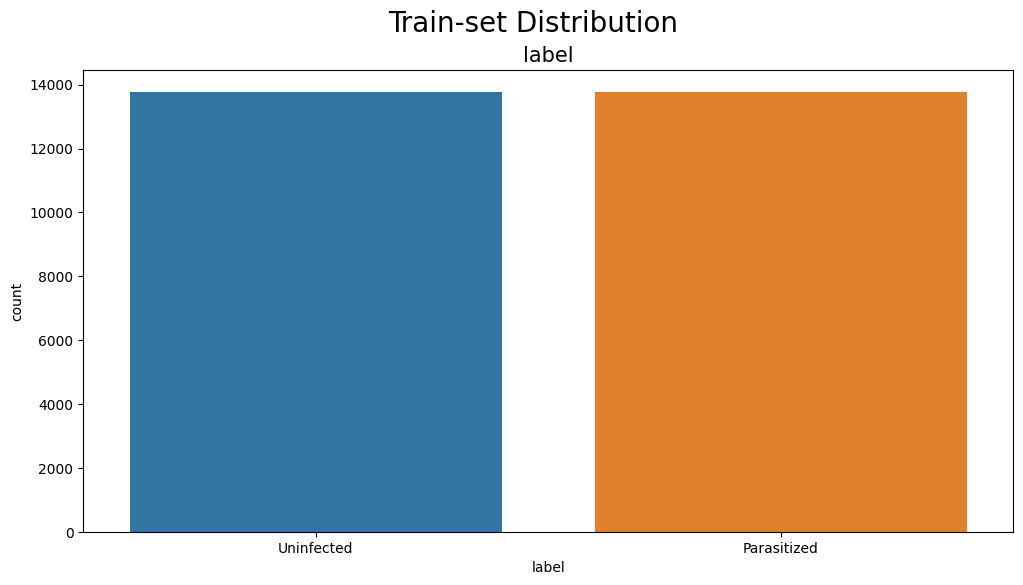

In [23]:
# Label Distribution Visualization
fig, ax = plt.subplots(ncols=1, figsize=(12,6))
plt.suptitle('Train-set Distribution', fontsize=20)
sns.countplot(x='label', data=train_df, palette='tab10')
ax.set_title('label', fontsize=15)

Text(0.5, 1.0, 'label')

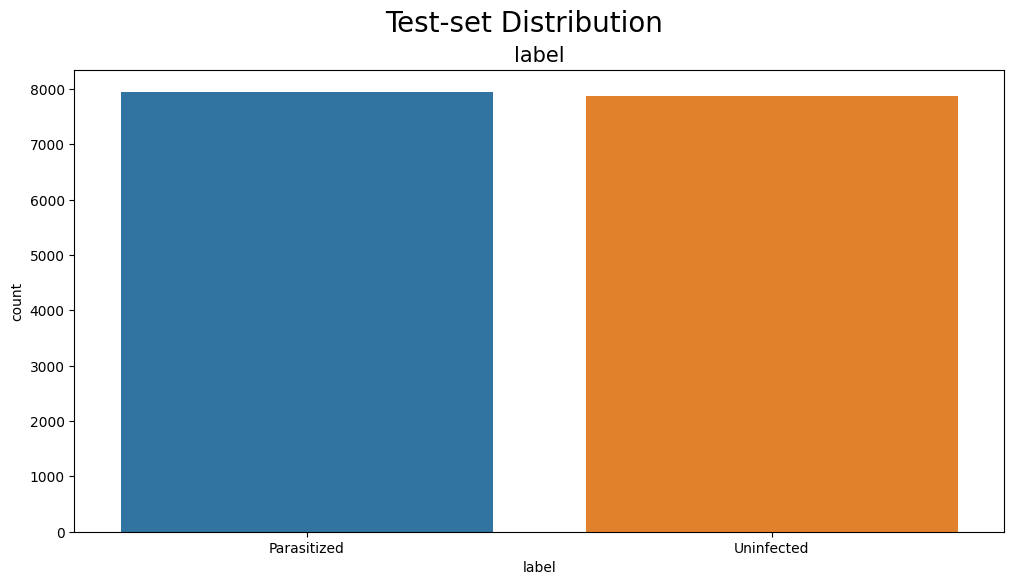

In [24]:
# Label Distribution Visualization
fig, ax = plt.subplots(ncols=1, figsize=(12,6))
plt.suptitle('Test-set Distribution', fontsize=20)
sns.countplot(x='label', data=test_df, palette='tab10')
ax.set_title('label', fontsize=15)

## Checking Image

### Normal Image

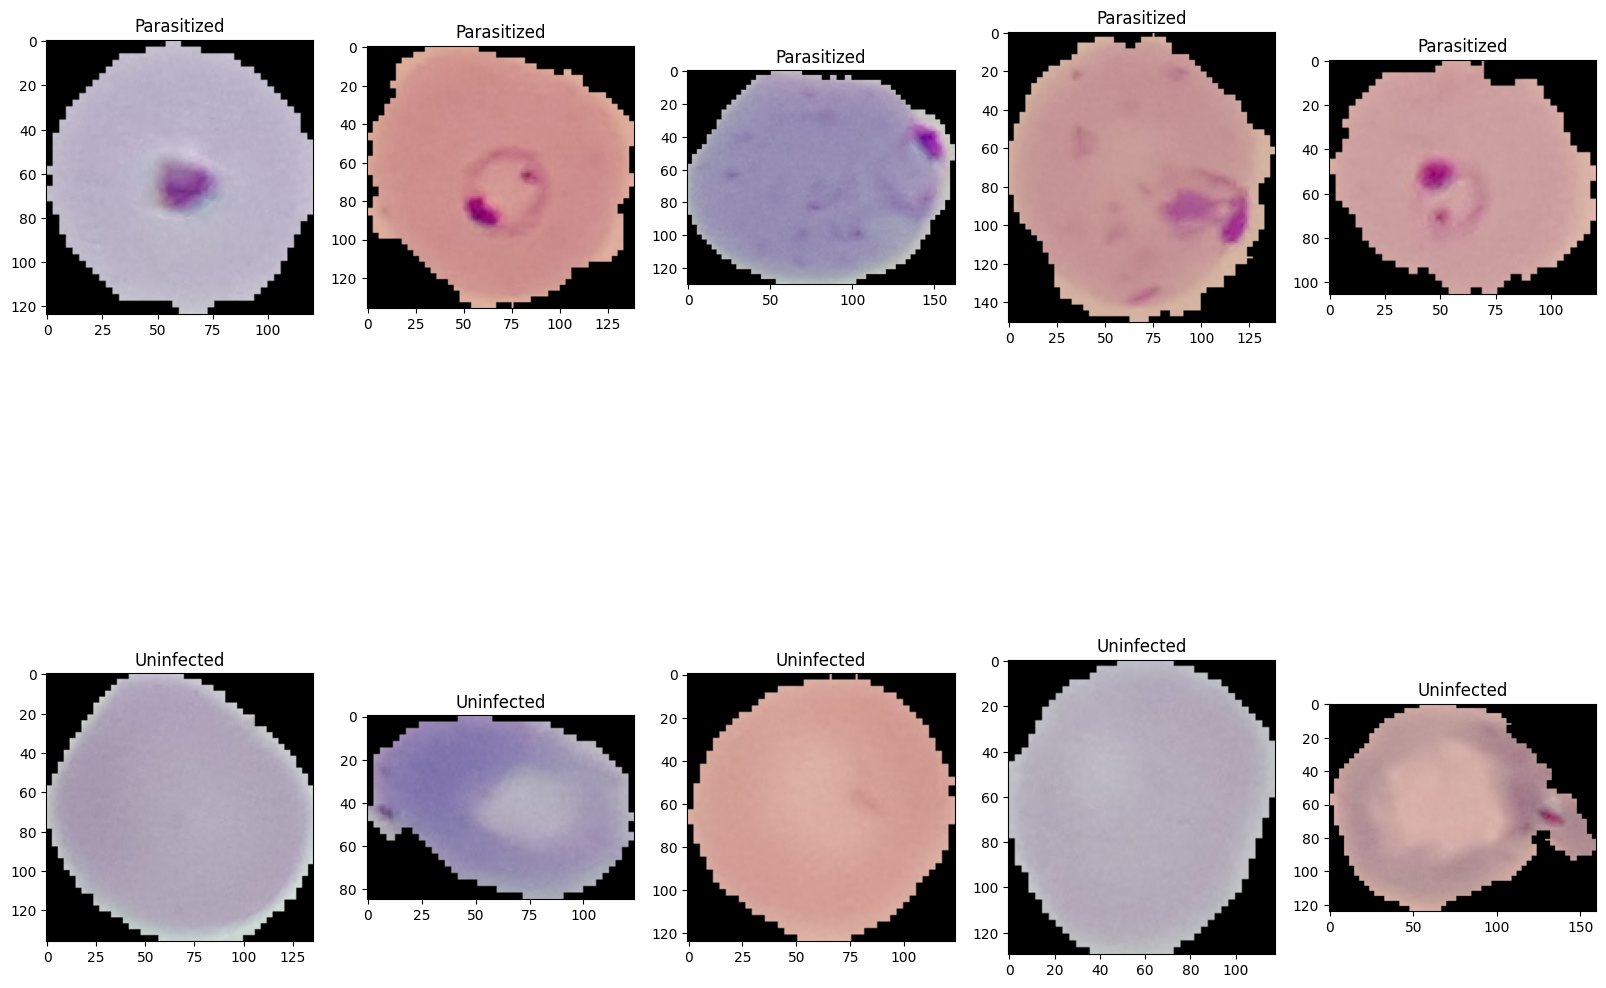

In [25]:
# define sample of dataset
parasitized_sample = (train_df[train_df['label']=='Parasitized']['images'].iloc[:5]).tolist()
unifected_sample = (train_df[train_df['label']=='Uninfected']['images'].iloc[:5]).tolist()

# Function visualize sample image
def visualize_samples(samples):
  fig,ax= plt.subplots(nrows=2, ncols=5, figsize= (20,15))
  for i, sample in enumerate(samples):
    img= cv2.imread(sample)
    ax[i//5, i%5].set_title(sample.split('/')[-2])
    ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()
# Execute the function
visualize_samples(parasitized_sample + unifected_sample)

### Black and White Image

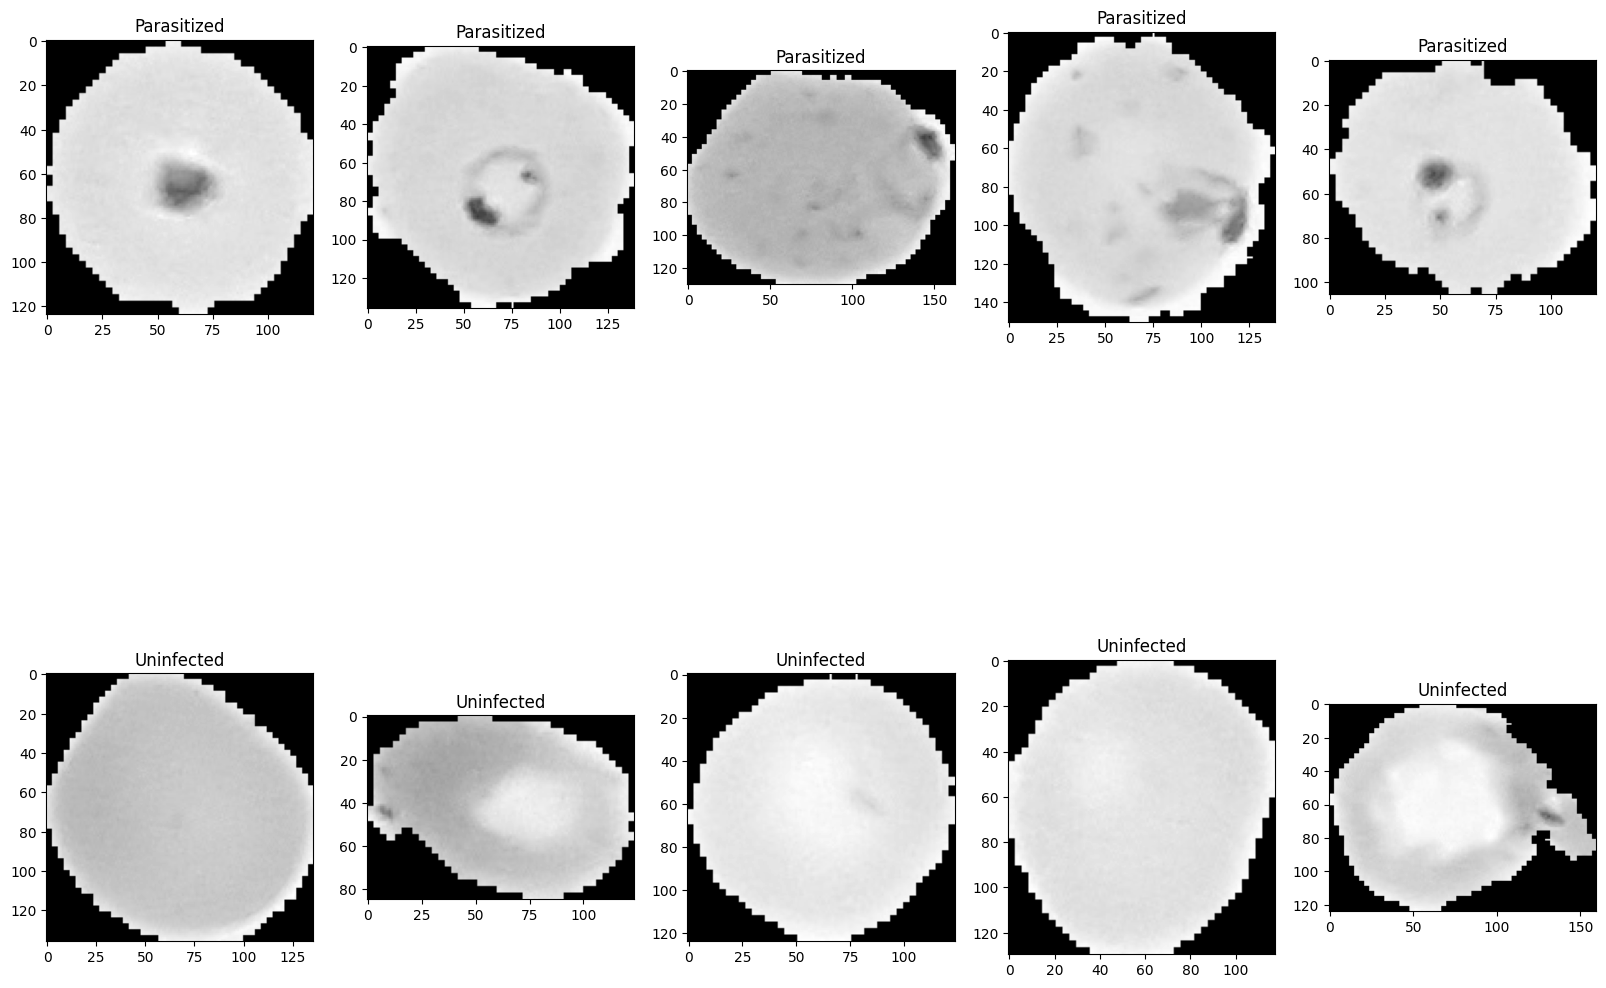

In [26]:
# define sample of dataset
parasitized_sample = (train_df[train_df['label']=='Parasitized']['images'].iloc[:5]).tolist()
unifected_sample = (train_df[train_df['label']=='Uninfected']['images'].iloc[:5]).tolist()

# Function visualize sample image
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 15))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        ax[i // 5, i % 5].set_title(sample.split('/')[-2])
        ax[i // 5, i % 5].imshow(img_gray, cmap='gray') 
    plt.show()
# Execute the function
visualize_samples(parasitized_sample + unifected_sample)

### Hue, Saturation, Brightness Image

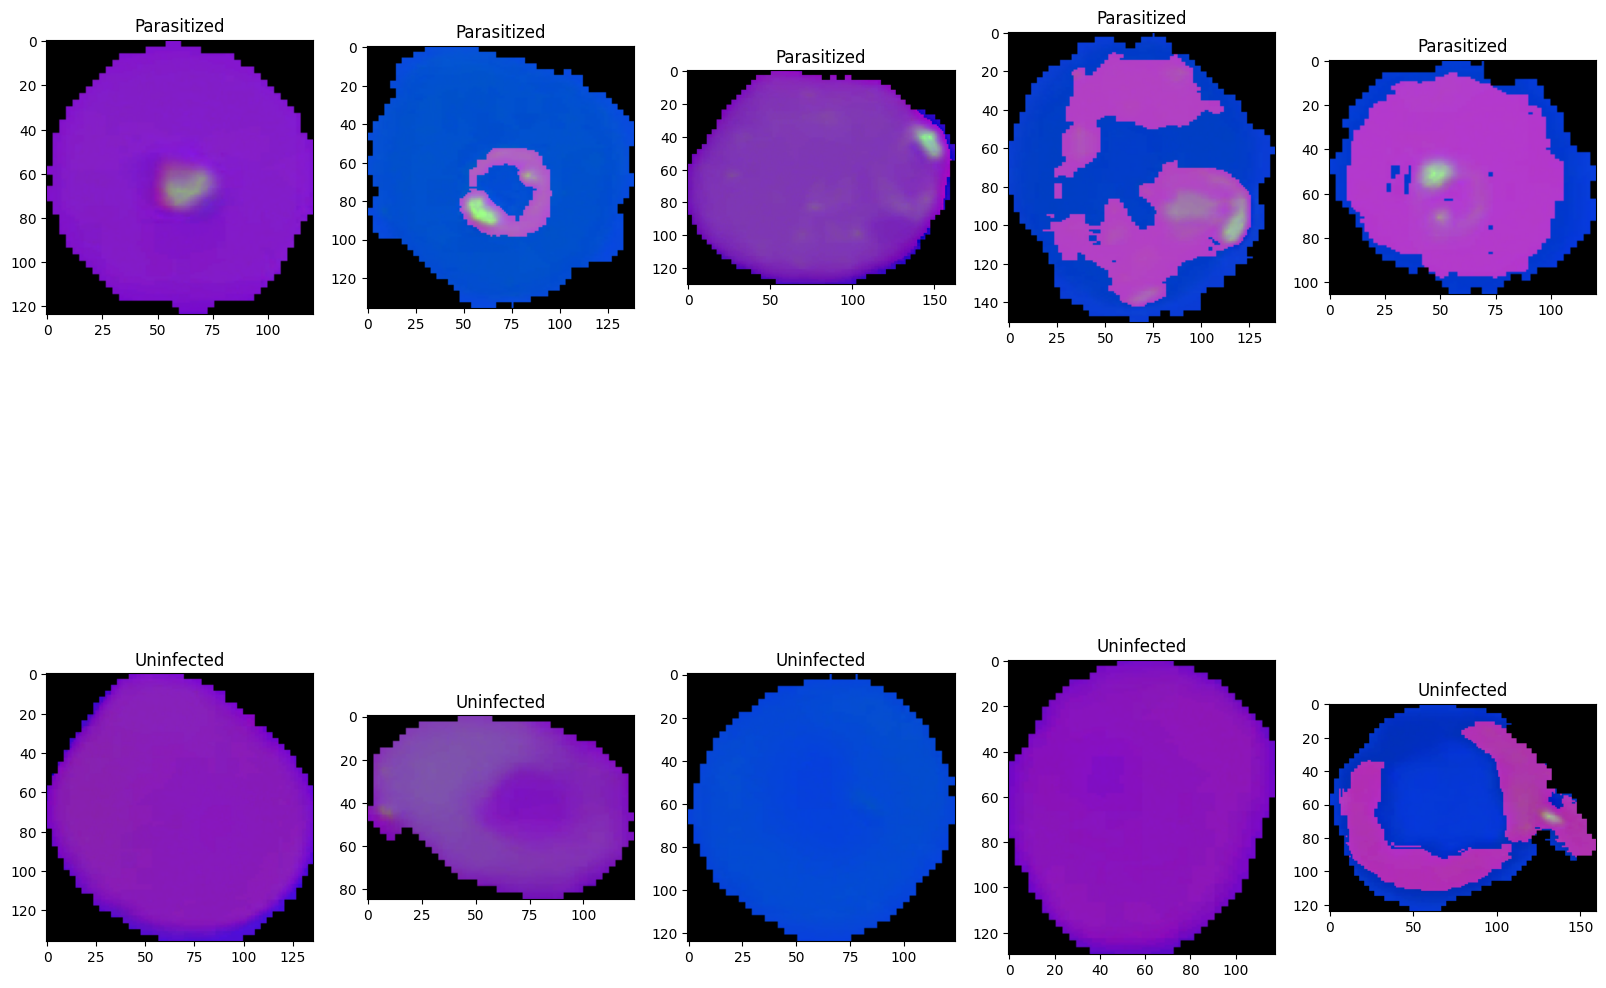

In [27]:
# define sample of dataset
parasitized_sample = (train_df[train_df['label']=='Parasitized']['images'].iloc[:5]).tolist()
unifected_sample = (train_df[train_df['label']=='Uninfected']['images'].iloc[:5]).tolist()

# Function visualize sample image
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 15))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  # Convert to HSB color space
        ax[i // 5, i % 5].set_title(sample.split('/')[-2])
        ax[i // 5, i % 5].imshow(img_hsv)
    plt.show()
# Execute the function
visualize_samples(parasitized_sample + unifected_sample)

### LUV Color Image

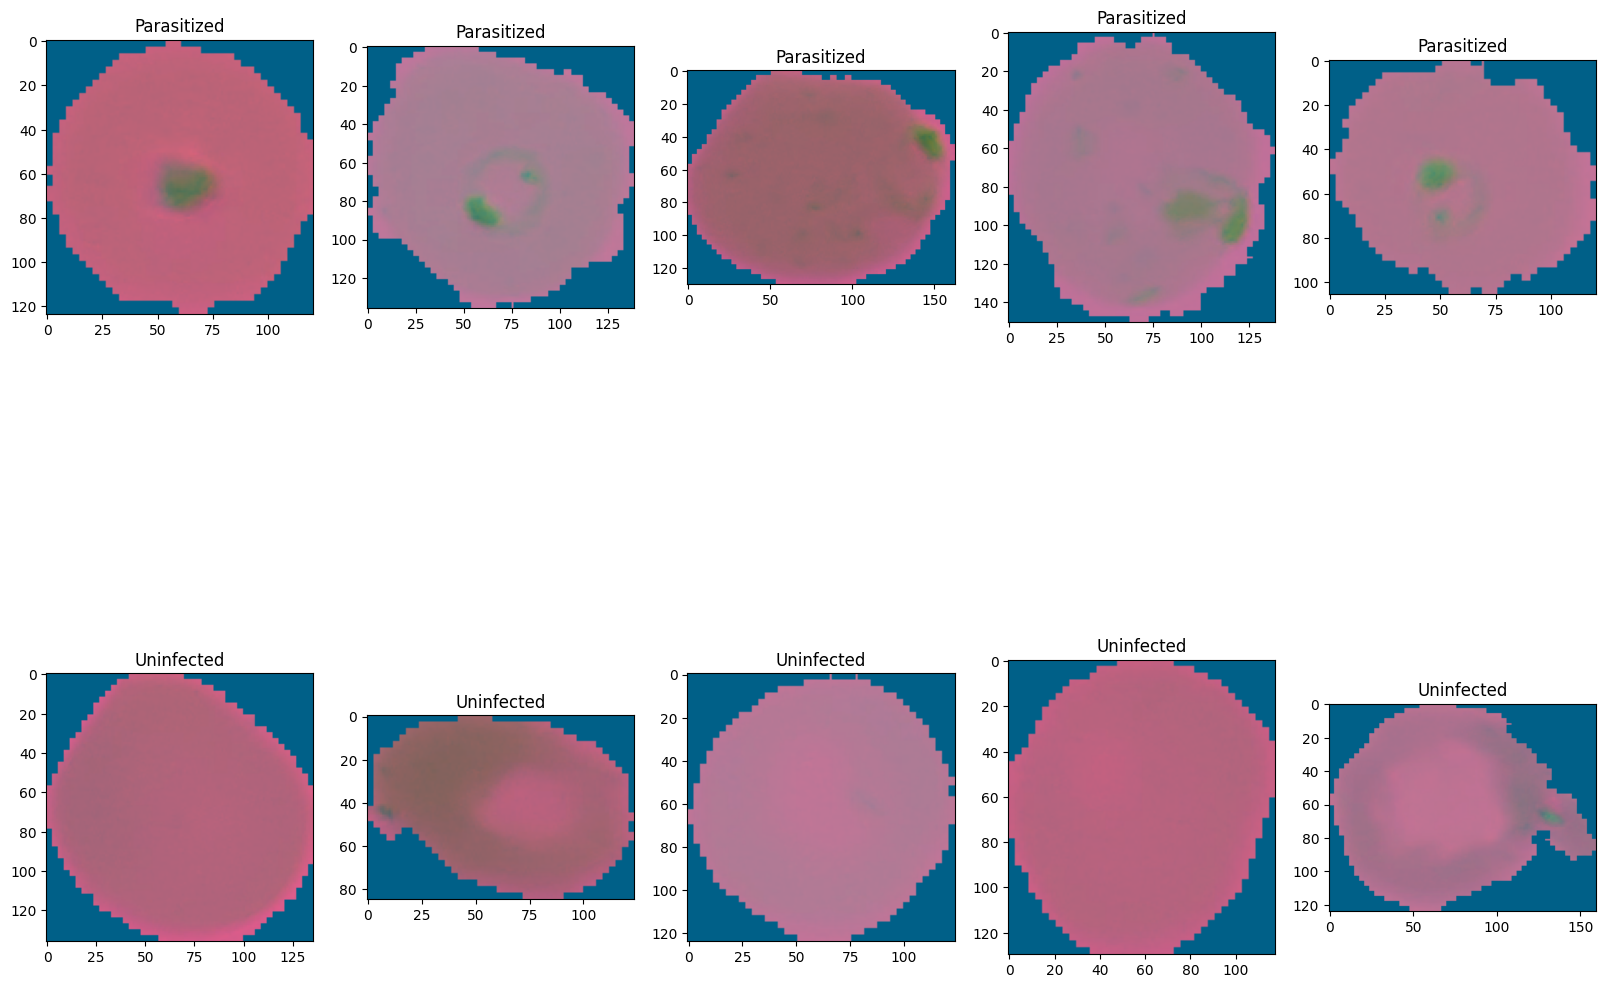

In [28]:
# define sample of dataset
parasitized_sample = (train_df[train_df['label']=='Parasitized']['images'].iloc[:5]).tolist()
unifected_sample = (train_df[train_df['label']=='Uninfected']['images'].iloc[:5]).tolist()

# Function visualize sample image
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 15))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        img_luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)  # Convert to LUV color space
        ax[i // 5, i % 5].set_title(sample.split('/')[-2])
        ax[i // 5, i % 5].imshow(img_luv)
    plt.show()
# Execute the function
visualize_samples(parasitized_sample + unifected_sample)

From the dataset we've known that :

- Both of Parasitized and Uninfected have a balance data

- Parasitized cells: Red blood cells undergo changes in size, shape, color, and structure as a result of malaria parasite invasion.

- Uninfected cells: Uninfected cells are healthy red blood cells, free from the malaria parasite, and appear normal in size, shape, and structure.

- Shape of image are < (150x150)

Notes :

- 
Upon initial observation, it is easy to mistake the "uninfected" data in columns 2 and 5 for parasitized samples. However, the presence of red or purple specks in these samples is actually indicative of white blood cells

- In column 1, the data "parasitized", at a glance, one might assume that the red-colored dots represent lymphocytes (white blood cells) due to their similar characteristics. However, it turns out that the red-colored dots actually represent infected red blood cells.

- Due to the incorrect assumption, it becomes necessary for the blood sample to undergo further verification by human experts

# **V. Feature Engineering**

## **Data Preprocessing and Augmentation**

In [29]:
# set img_height, img_width, and batch_size
img_height= 100
img_width= 100
batch_size= 20

Splitting data train into train-set and val-set

In [30]:
# Train Set & Val Set
train_images, val_images = train_test_split(train_df, test_size=0.3, random_state=7, stratify=train_df[['label']])

In [31]:
# Size Summary
print('Train Set shape : ', train_images.shape)
print('Val Set shape : ', val_images.shape)
print('Test Set shape : ', test_df.shape)

Train Set shape :  (19290, 2)
Val Set shape :  (8268, 2)
Test Set shape :  (15832, 2)


Augmentation in CNN: Applying transformations (flipping, rotation, scaling, etc.) to training images to improve model generalization and reduce overfitting

In [32]:
# create image generator
train_datagen = ImageDataGenerator(
    rescale=1./255, #normalisasi pixel with scale 0-1
    rotation_range=50, #rotate image
    width_shift_range=0.2, # shift image width range 20% (left/right)
    height_shift_range=0.2, # shift image height range 20% (upper/lower)
    shear_range=0.2, # shifting the image but get the effect of distortion
    zoom_range=0.3, # zoom image
    horizontal_flip=True) # flippig image

vaL_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [33]:
# Tensorflow pipeline for augmentation

train= train_datagen.flow_from_dataframe(dataframe= train_images,
                                            x_col= 'images',
                                            y_col= 'label',
                                            target_size= (img_height,img_width),
                                            class_mode= 'binary',
                                            batch_size= batch_size,
                                            shuffle= True,
                                            seed= 7
                                         )

val= vaL_datagen.flow_from_dataframe(dataframe= val_images,
                                        x_col= 'images',
                                        y_col= 'label',
                                        target_size= (img_height,img_width),
                                        class_mode= 'binary',
                                        batch_size= batch_size,
                                        shuffle= False,
                                        seed= 7
                                      )

test= test_datagen.flow_from_dataframe(dataframe= test_df,
                                        x_col= 'images',
                                        y_col= 'label',
                                        target_size= (img_height,img_width),
                                        class_mode= 'binary',
                                        batch_size= batch_size,
                                        shuffle= False,
                                        seed= 7
                                       )

Found 19290 validated image filenames belonging to 2 classes.
Found 8268 validated image filenames belonging to 2 classes.
Found 15832 validated image filenames belonging to 2 classes.


Text(0.5, 1.0, 'Original')

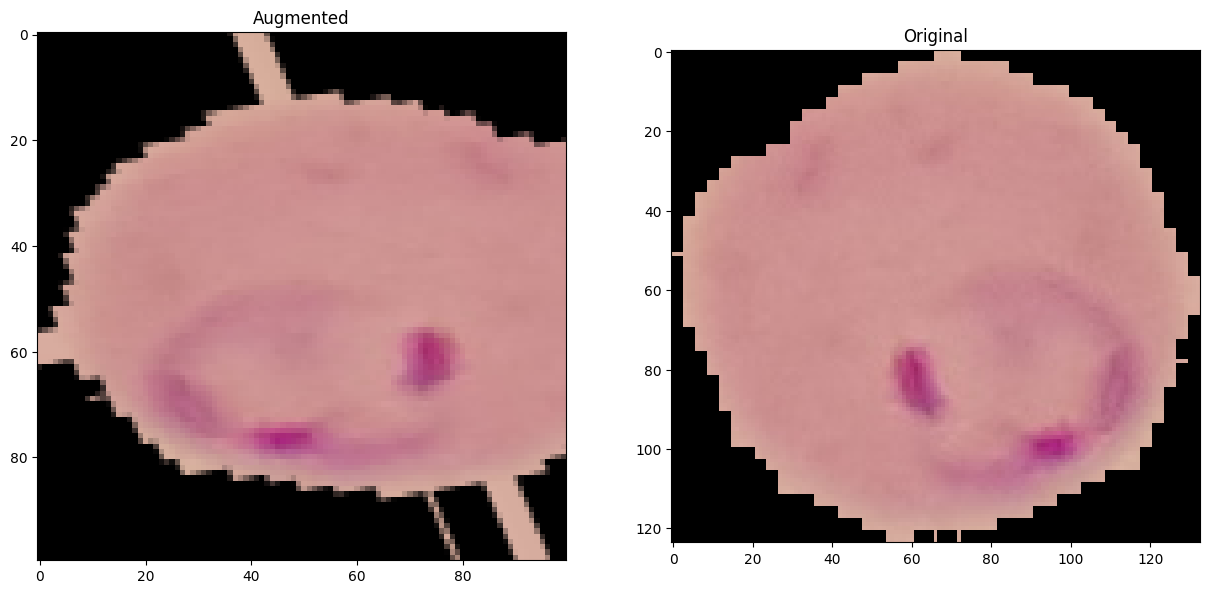

In [34]:
# Show augmented images
images, labels  = next(train)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
ax[0].imshow(images[0])
ax[0].set_title('Augmented')
original = plt.imread(train.filepaths[train.index_array[batch_size*(train.batch_index-1)]])
ax[1].imshow(original)
ax[1].set_title('Original')

In [35]:
for image_batch , label_batch in train:
  print(image_batch.shape)
  print(label_batch.shape)
  break

(20, 100, 100, 3)
(20,)


In [36]:
# key_value for labels binary
key_value = train.class_indices
key_value

{'Parasitized': 0, 'Uninfected': 1}

From the dataset we've known that :

- `0` is for Parasitized

- `1` is for Uninfected

# **VI. Base Model**

In [37]:
# define callback
callbacks= [
            EarlyStopping(monitor= 'val_loss', mode='min', patience= 4, verbose=1),
            ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only= True)
]

## **Model Definition**

Definition of the model :

- `filter` : refers to the number of random features

- `kernel_size` : refers to the size of the filter or window that moves across during convolutional operation

- `padding 'same` : that the input image is padded with zeros so that the output feature map has the same spatial dimensions as the input

- `activation 'relu'` : commonly used

- `input_shape` : resize data manually (100, 100, 3) means that image resize to 100 x 100 and has a RGB color

- `pool_size` : parameter to determines the size of the pooling window that moves across the input feature map

- `strides` : parameter determines the step size or the amount by which the pooling window moves horizontally and vertically across the input feature map

- `Dense = 64` : number of neuron

- `sigmoid activation` : used for output layer where the class is binary

- `binary_crossentropy` : where the class is binary

I use Sequential and Functional API as base model :

- 4 Convolutional with filter from 8 to 64, activation we use `relu`, we use padding `same`

- 1 Hidden layer with neuron 64, activation we use `relu`

- Output layer, activation we use `sigmoid` for binary classification

- Optimizer `Adam`

### Sequential API

In [38]:
# Sequential API Method

# Input shape
input= [img_height,img_width,3]

# Model Process
model_imp1 = Sequential()
# Convolutional 1
model_imp1.add(Conv2D(filters=8, kernel_size=3, activation= 'relu', padding='same', input_shape= input))
model_imp1.add(MaxPooling2D(pool_size=2, strides=2))

# Convolutional 2
model_imp1.add(Conv2D(filters=16,kernel_size=3, activation='relu', padding='same'))
model_imp1.add(MaxPooling2D(pool_size=2, strides=2))

# Convolutional 3
model_imp1.add(Conv2D(filters=32,kernel_size=3, activation='relu', padding='same'))
model_imp1.add(MaxPooling2D(pool_size=2, strides=2))

# Convolutional 4
model_imp1.add(Conv2D(filters=64,kernel_size=3, activation='relu', padding='same'))
model_imp1.add(MaxPooling2D(pool_size=2, strides=2))

# Flatten layer 
model_imp1.add(Flatten())

# Fully Connected Layer
model_imp1.add(Dense(64, activation='relu'))

# Output l
model_imp1.add(Dense(1, activation='sigmoid'))

# Compile Model
model_imp1.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['Accuracy'])


#Summary
model_imp1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0

### Functional API

In [39]:
# Define Initial Functional Model

input = keras.Input(shape=(img_width, img_width, 3))
conv_1 = keras.layers.Conv2D(8, (3, 3), padding='same', activation='relu')(input)
maxpool_1 = keras.layers.MaxPooling2D(pool_size=2, strides=2)(conv_1)
conv_2 = keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')(maxpool_1)
maxpool_2 = keras.layers.MaxPooling2D(pool_size=2, strides=2)(conv_2)
conv_3 = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(maxpool_2)
maxpool_3 = keras.layers.MaxPooling2D(pool_size=2, strides=2)(conv_2)
conv_4 = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(maxpool_3)
maxpool_4 = keras.layers.MaxPooling2D(pool_size=2, strides=2)(conv_3)
flatten = keras.layers.Flatten()(maxpool_4)
dense_1 = keras.layers.Dense(64, activation='relu')(flatten)
output_func= keras.layers.Dense(1, activation='sigmoid')(dense_1)

model_imp2 = keras.Model(inputs=input, outputs=output_func)

# Compile
model_imp2.compile(loss='binary_crossentropy',
                         optimizer='Adam',
                         metrics=['Accuracy'])
model_imp2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 8)       224       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 50, 50, 16)        1168      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 25, 25, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 25, 25, 32)        4640  

## **Model Training**

### Sequential API

In [40]:
%%time
history_s= model_imp1.fit(train, batch_size= batch_size, 
                           epochs= 20, validation_data= val,
                           callbacks= callbacks)

Epoch 1/20
965/965 [==============================] - 96s 88ms/step - loss: 0.4960 - Accuracy: 0.7302 - val_loss: 0.1894 - val_Accuracy: 0.9545
Epoch 2/20
965/965 [==============================] - 83s 86ms/step - loss: 0.2391 - Accuracy: 0.9178 - val_loss: 0.1602 - val_Accuracy: 0.9554
Epoch 3/20
965/965 [==============================] - 83s 86ms/step - loss: 0.2243 - Accuracy: 0.9246 - val_loss: 0.1387 - val_Accuracy: 0.9557
Epoch 4/20
965/965 [==============================] - 92s 95ms/step - loss: 0.2118 - Accuracy: 0.9292 - val_loss: 0.1321 - val_Accuracy: 0.9590
Epoch 5/20
965/965 [==============================] - 89s 92ms/step - loss: 0.2046 - Accuracy: 0.9291 - val_loss: 0.1418 - val_Accuracy: 0.9584
Epoch 6/20
965/965 [==============================] - 88s 91ms/step - loss: 0.1986 - Accuracy: 0.9288 - val_loss: 0.1263 - val_Accuracy: 0.9598
Epoch 7/20
965/965 [==============================] - 90s 93ms/step - loss: 0.1949 - Accuracy: 0.9314 - val_loss: 0.1252 - val_Accuracy:

### Functional API

In [41]:
%%time
history_f= model_imp2.fit(train, batch_size= batch_size, 
                           epochs= 20, validation_data= val,
                           callbacks= callbacks)

Epoch 1/20
965/965 [==============================] - 89s 90ms/step - loss: 0.6025 - Accuracy: 0.6314 - val_loss: 0.2241 - val_Accuracy: 0.9461
Epoch 2/20
965/965 [==============================] - 82s 85ms/step - loss: 0.2579 - Accuracy: 0.9101 - val_loss: 0.1624 - val_Accuracy: 0.9534
Epoch 3/20
965/965 [==============================] - 81s 84ms/step - loss: 0.2347 - Accuracy: 0.9208 - val_loss: 0.1504 - val_Accuracy: 0.9513
Epoch 4/20
965/965 [==============================] - 82s 85ms/step - loss: 0.2288 - Accuracy: 0.9241 - val_loss: 0.1458 - val_Accuracy: 0.9571
Epoch 5/20
965/965 [==============================] - 81s 84ms/step - loss: 0.2145 - Accuracy: 0.9265 - val_loss: 0.1340 - val_Accuracy: 0.9578
Epoch 6/20
965/965 [==============================] - 81s 84ms/step - loss: 0.2113 - Accuracy: 0.9280 - val_loss: 0.1325 - val_Accuracy: 0.9557
Epoch 7/20
965/965 [==============================] - 81s 83ms/step - loss: 0.2068 - Accuracy: 0.9297 - val_loss: 0.1320 - val_Accuracy:

## **Model Evaluation**

### Sequential API

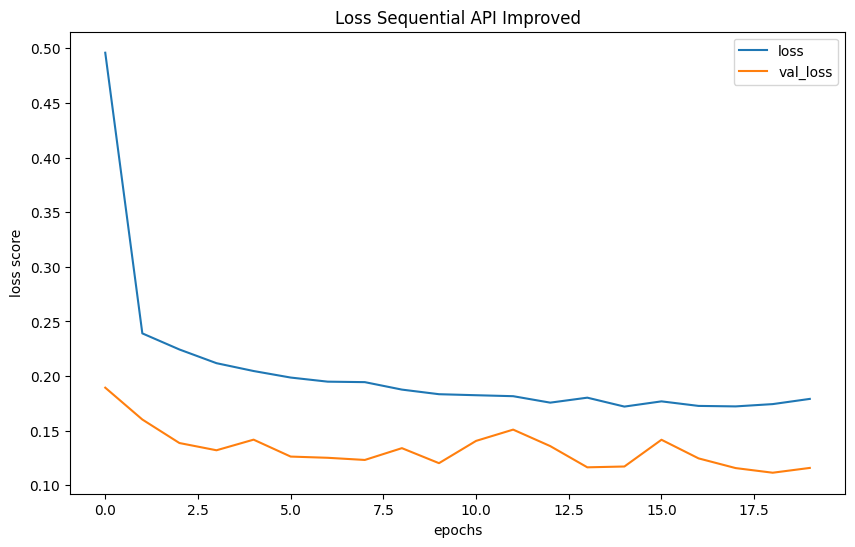

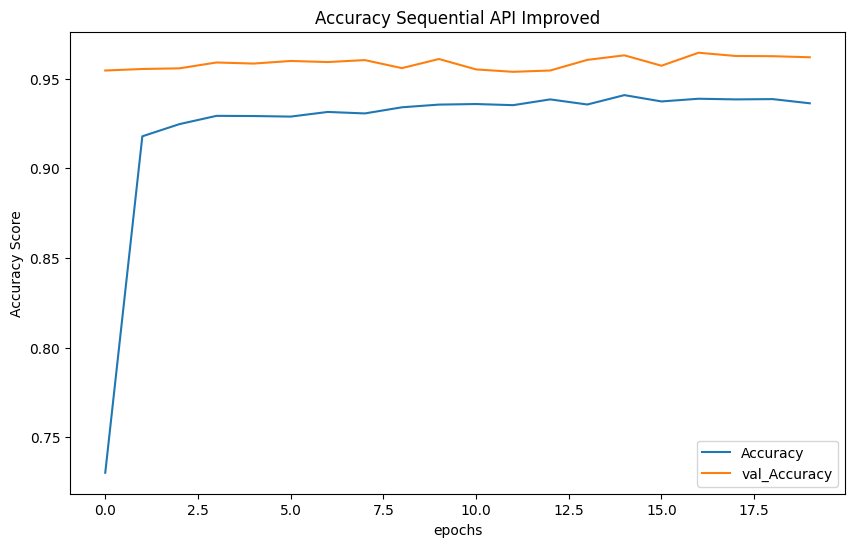

In [42]:
# Evaluation of Base Model

imp_seq = pd.DataFrame(history_s.history)

# Visualization Sequential
imp_seq[['loss','val_loss']].plot(figsize=(10, 6))
plt.title('Loss Sequential API Improved')
plt.ylabel('loss score')
plt.xlabel('epochs')
plt.show()

# Visualization Sequential
imp_seq[['Accuracy','val_Accuracy']].plot(figsize=(10, 6))
plt.title('Accuracy Sequential API Improved')
plt.ylabel('Accuracy Score')
plt.xlabel('epochs')
plt.show()

In [43]:
test_results1 = model_imp1.evaluate(test, verbose=0)
print(f'Test Loss     : {test_results1[0]:.4f}')
print(f'Test Accuracy : {test_results1[1]:.4f}')

Test Loss     : 0.1291
Test Accuracy : 0.9563


792/792 [==============================] - 20s 25ms/step
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      7952
           1       0.94      0.97      0.96      7880

    accuracy                           0.96     15832
   macro avg       0.96      0.96      0.96     15832
weighted avg       0.96      0.96      0.96     15832



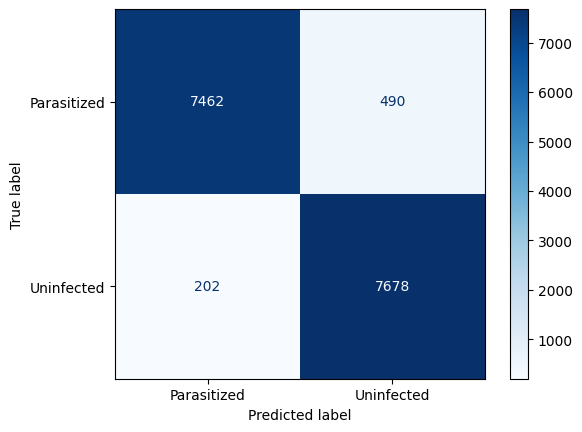

In [44]:
y_pred_s = model_imp1.predict(test)
y_pred_final_s = []

for i in y_pred_s:
  if i > 0.5:
    i = 1
    y_pred_final_s.append(i)
  else:
    i = 0
    y_pred_final_s.append(i)


print(classification_report(test.classes, y_pred_final_s))

# Confusion matrix
cm = confusion_matrix(test.classes, y_pred_final_s)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Parasitized', 'Uninfected'])
disp.plot(cmap='Blues')
plt.show()

### Functional API

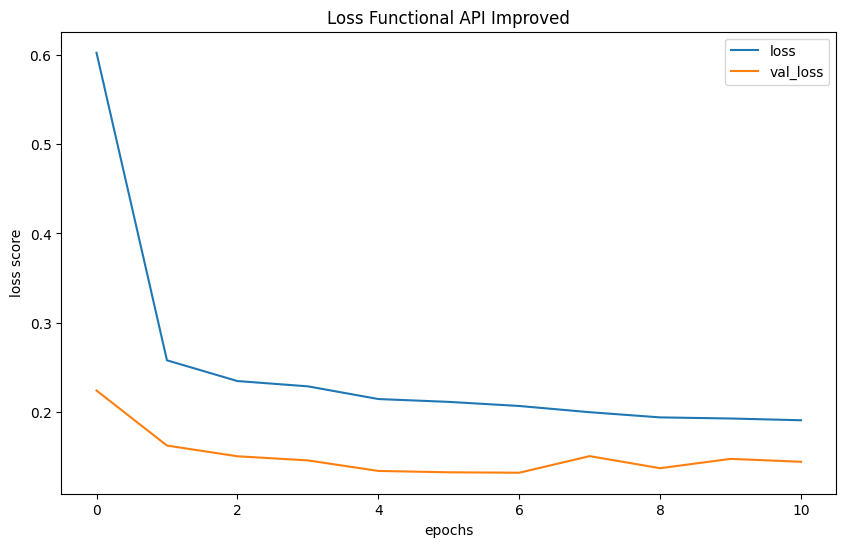

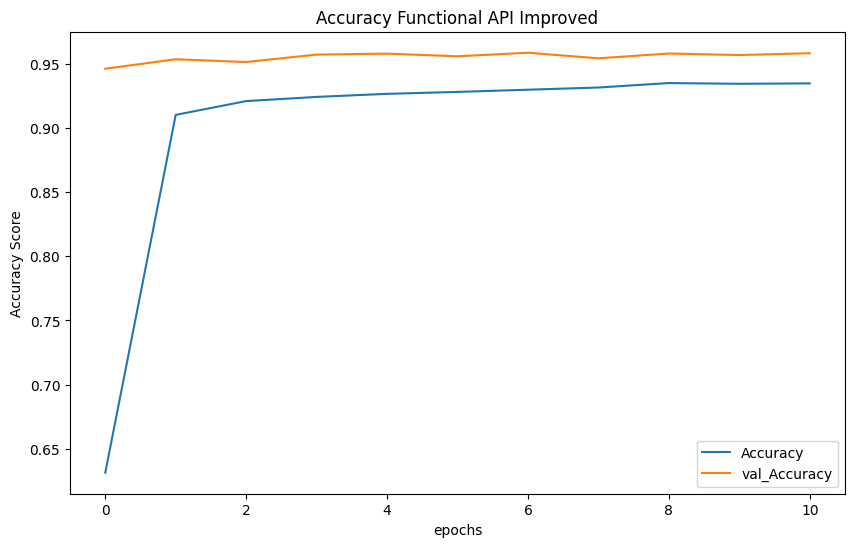

In [45]:
# Evaluation of Base Model

imp_func = pd.DataFrame(history_f.history)

# Visualization Sequential
imp_func[['loss','val_loss']].plot(figsize=(10, 6))
plt.title('Loss Functional API Improved')
plt.ylabel('loss score')
plt.xlabel('epochs')
plt.show()

# Visualization Sequential
imp_func[['Accuracy','val_Accuracy']].plot(figsize=(10, 6))
plt.title('Accuracy Functional API Improved')
plt.ylabel('Accuracy Score')
plt.xlabel('epochs')
plt.show()

In [46]:
test_results2 = model_imp2.evaluate(test, verbose=0)
print(f'Test Loss     : {test_results2[0]:.4f}')
print(f'Test Accuracy : {test_results2[1]:.4f}')

Test Loss     : 0.1626
Test Accuracy : 0.9525


792/792 [==============================] - 25s 31ms/step
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      7952
           1       0.93      0.98      0.95      7880

    accuracy                           0.95     15832
   macro avg       0.95      0.95      0.95     15832
weighted avg       0.95      0.95      0.95     15832



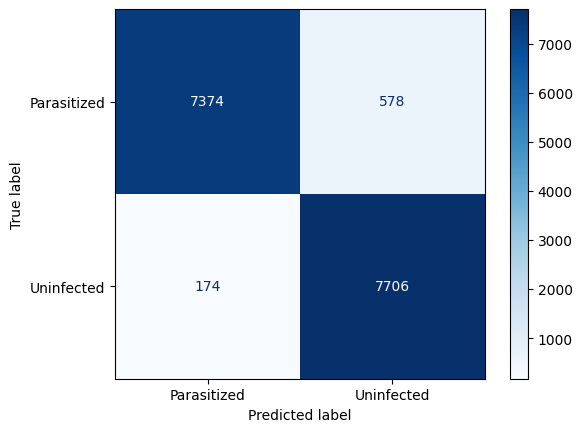

In [47]:
y_pred_f = model_imp2.predict(test)
y_pred_final_f = []

for i in y_pred_f:
  if i > 0.5:
    i = 1
    y_pred_final_f.append(i)
  else:
    i = 0
    y_pred_final_f.append(i)


print(classification_report(test.classes, y_pred_final_f))

# Confusion matrix
cm = confusion_matrix(test.classes, y_pred_final_f)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Parasitized', 'Uninfected'])
disp.plot(cmap='Blues')
plt.show()

After evaluating both of base models, either sequential nor functional have a great precision score

According to the results, the functional API improvedmodel is a good model for improvement because it has a quick run-time.

# **VII. Model Improvement**

### **Transfer Learning**

### Xception

The Xception model consists of separable depthwise convolutional layers and is equipped with residual connections. This makes the Xception model easy to define and modify. With just 30 to 40 lines of code and high-level libraries like Keras or TensorFlow-Slim, the Xception model can be implemented effectively. This advantage of simplicity allows Xception to have a relatively lower cost compared to some other models

[journal link](https://publication.petra.ac.id/index.php/teknik-informatika/article/view/12738)

In [48]:
# define transfer learning
input_shape = (100, 100, 3)
pretrained_model = tf.keras.applications.Xception(include_top=False, 
                                                  input_shape=input_shape,pooling='avg')
pretrained_model.trainable = False

83683744/83683744 [==============================] - 1s 0us/step


- `include_top = False` : fully connected layer create manually

#### Model Definition

I use functional API consists 2 hidden layer with 64, 32 neuron, activation `relu` for base model using transfer learning `Xception`, and `Adam` as optimizer and add Dropout to optimize model by drop feature or neuron who didn't give more impact

In [50]:
# Define Initial Functional API base model use transfer learning

tfl = pretrained_model.output
flatten = keras.layers.Flatten()(tfl)
h1 = keras.layers.Dense(64, activation='relu')(flatten) # hidden layer 1
d1 = Dropout(rate=0.1)(h1)
h2 = keras.layers.Dense(32, activation='relu')(d1) # hidden layer 2
d2 = Dropout(rate=0.1)(h2)
output_func= keras.layers.Dense(1, activation='sigmoid')(d2)

model_xc = keras.Model(inputs=pretrained_model.input, outputs=output_func)

# Compile
model_xc.compile(loss='binary_crossentropy',
                         optimizer='Adam',
                         metrics=['Accuracy'])

#### Model Training

In [51]:
%%time

history_tf2= model_xc.fit(train, batch_size= batch_size, 
                           epochs= 20, validation_data= val,
                           callbacks= callbacks)

Epoch 1/20
965/965 [==============================] - 98s 97ms/step - loss: 0.3466 - Accuracy: 0.8565 - val_loss: 0.2856 - val_Accuracy: 0.8849
Epoch 2/20
965/965 [==============================] - 104s 107ms/step - loss: 0.3127 - Accuracy: 0.8722 - val_loss: 0.2694 - val_Accuracy: 0.8881
Epoch 3/20
965/965 [==============================] - 92s 95ms/step - loss: 0.3053 - Accuracy: 0.8753 - val_loss: 0.2552 - val_Accuracy: 0.8959
Epoch 4/20
965/965 [==============================] - 101s 104ms/step - loss: 0.3000 - Accuracy: 0.8798 - val_loss: 0.2651 - val_Accuracy: 0.8920
Epoch 5/20
965/965 [==============================] - 91s 95ms/step - loss: 0.2994 - Accuracy: 0.8799 - val_loss: 0.2584 - val_Accuracy: 0.8971
Epoch 6/20
965/965 [==============================] - 90s 93ms/step - loss: 0.2924 - Accuracy: 0.8813 - val_loss: 0.2612 - val_Accuracy: 0.8922
Epoch 7/20
965/965 [==============================] - 91s 94ms/step - loss: 0.2893 - Accuracy: 0.8844 - val_loss: 0.2497 - val_Accur

#### Model Evaluation

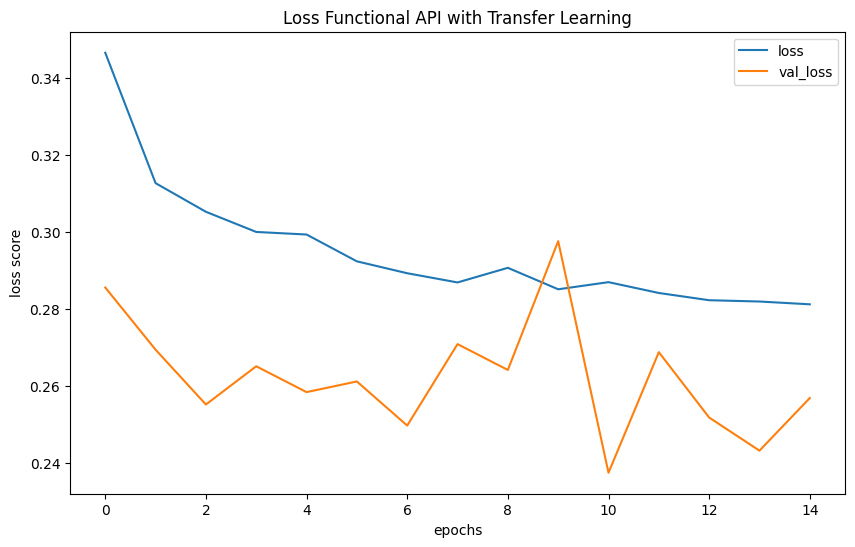

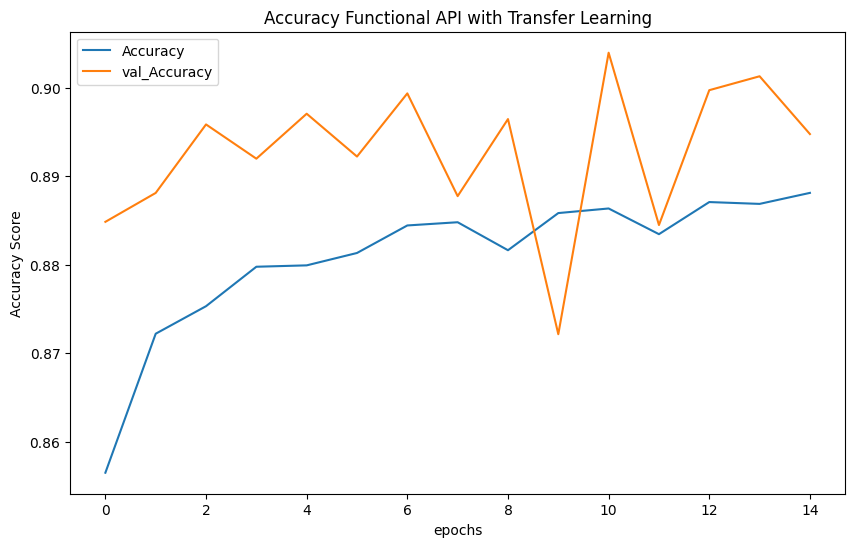

In [52]:
# Evaluation of Base Model

base_iv3 = pd.DataFrame(history_tf2.history)

# Visualization Sequential
base_iv3[['loss','val_loss']].plot(figsize=(10, 6))
plt.title('Loss Functional API with Transfer Learning')
plt.ylabel('loss score')
plt.xlabel('epochs')
plt.show()

# Visualization Sequential
base_iv3[['Accuracy','val_Accuracy']].plot(figsize=(10, 6))
plt.title('Accuracy Functional API with Transfer Learning')
plt.ylabel('Accuracy Score')
plt.xlabel('epochs')
plt.show()

In [53]:
test_results = model_xc.evaluate(test, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

Test Loss     : 0.2494
Test Accuracy : 0.8948


792/792 [==============================] - 31s 39ms/step
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      7952
           1       0.94      0.79      0.86      7880

    accuracy                           0.87     15832
   macro avg       0.88      0.87      0.87     15832
weighted avg       0.88      0.87      0.87     15832



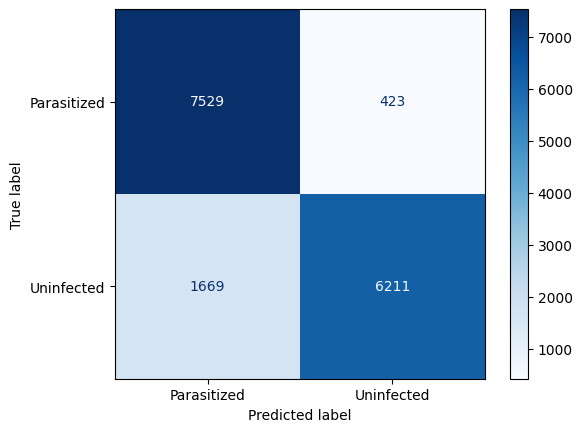

In [64]:
y_pred_2 = model_xc.predict(test)
y_pred_final_2 = []

for i in y_pred_2:
  if i > 0.8: # threshold improvement
    i = 1
    y_pred_final_2.append(i)
  else:
    i = 0
    y_pred_final_2.append(i)


print(classification_report(test.classes, y_pred_final_2))

# Confusion matrix
cm = confusion_matrix(test.classes, y_pred_final_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Parasitized', 'Uninfected'])
disp.plot(cmap='Blues')
plt.show()

We focus on precision score because the score means patient who are infected by parasitic is classified as uninfected which malaria disease is one of the deadliest diseases in which there are 241 million cases of malaria worldwide, and around 627,000 deaths from malaria are reported (WHO, 2020)

Model Analysis :

- After we use a threshold improvement we get a precision score of 95% which is greater than the base model but the recall score decreases

- It concludes that the model is weak to classify the data from parasitized and uninfected. The solution is capture for further data need to be clearer cause it can be more specific to divide which red blood cells are infected by parasites and which white blood cell

- The model has a good fitting

# **IX. Model Saving**

In [55]:
# Save ANN Model
model_xc.save('model_xc.h5')

# **XI. Conclusion**

Exploratory Data Analysis :

- Both classes data have a balance data

- Both classes have strong characteristics but, when the blood sample has noise (nonred blood cell) it's difficult to divide the data

- Both classes data have shape 150 x 150

Model Analysis :

- From the base model, the Functional API choices as a good model and need to be improved

- The model has a good fitting

- The model is weak to classify the data from parasitized and uninfected. To increase the rate of prediction, we need to capture clearer image

- We focus on the precision score because this score explains that there are patients who should have been promptly followed up due to infection, but due to misclassification, these patients are at risk of their lives if not treated immediately.